#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
from tqdm.notebook import tqdm
import spacy
import spacytextblob
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
import yfinance as yf
import datetime as dt
import pandas_datareader.data as web
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import itertools

#### Defined the function to extract tweets

In [2]:
def collect_tweets(user, n_tweets, min_date):

    tweets = []

    for i, tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper(f"from:{user}␣ 􏰑→since:{min_date}").get_items())):

        if i > n_tweets: 
            break

        tweets.append([tweet.date, tweet.content, tweet.likeCount, tweet.replyCount, tweet.retweetCount])
        
    tweets = pd.DataFrame(tweets, columns=['date','content', 'like Count', 'reply count', 'retweet count']) 
    return tweets 

## TESLA ANALYSIS

#### Extracted all the Elon Musk's tweets from 29/06/2010 (Tesla stock listing)

In [144]:
Elon_Musk=collect_tweets(user="elonmusk", n_tweets=np.inf, min_date="2010-06-29")

##### SENTIMENT INDEX CREATION

In [3]:
nlp = spacy.load('en_core_web_md')

In [146]:
word1='electric'
word2='car'

ms1 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word1]]]), n=100)
ms2 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word2]]]), n=100)
Tesla_syn = [nlp.vocab.strings[w] for w in ms1[0][0]]
Tesla2_syn = [nlp.vocab.strings[w] for w in ms2[0][0]]
Tesla_syn.extend(Tesla2_syn)
Tesla_syn.extend(['Tesla', 'TESLA', 'self driving', 'Nasdaq', 'NASDAQ'])
print(Tesla_syn)

['electric', 'Non-Electric', 'Non-Electrical', 'Nuclear-Generated', 'SERVO', 'oil-fired', 'LIQUEFIED', 'gas', 'MOTOR', 'water-heater', 'power', 'POWE', 'Enery', 'energy', 'KITCHENWARE', 'solar', 'SOLAR-POWERED', 'GENERATORS', 'non-powered', 'electronic-based', 'consumer-electronics', 'ONAN', 'feul', 'HARMONICAS', 'HARMONICA', 'guitar', 'REWIRED', 'WOOD-BURNING', 'Two-Wheeler', 'Electro-Mechanical', 'PEDALING', 'ACOUSTICALLY', 'STEAMBATH', 'steam', 'Diesel-Electric', 'EQUIPEMENT', 'battery-powered', 'SKIMMER', 'heat', 'HEATS', 'FIXTURES', 'microwave-safe', 'cars', 'AUTOMOBILES', 'hybird', 'gasoline-powered', 'lights', 'Floodlights', 'iginition', 'VACUUMS', 'lead-acid', 'air-conditioner', 'ARMATURE', 'Sous-vide', 'TWO-CAR', 'INVERTER', 'steel', 'Cold-Rolled', 'TURBINES', 'wind', 'CRIMPED', 'wire', 'MAGNETIZED', 'non-metal', 'metal', 'Off-Highway', 'COMBUSTIBLES', 'car', 'AUTOMOBILE', 'battery', 'BATT', 'OPEN-HEARTH', 'OVERCHARGING', 'Motorcar', 'front-loading', 'SKIMMERS', 'INDUSTIAL', '

In [4]:
nlp.add_pipe('spacytextblob')

#### Created a df for tweets having at least one word in common with our list

In [148]:
Tesla = Elon_Musk

sent=[]
subj=[]

for j in range(0,len(Elon_Musk)):
    
    row = Elon_Musk.iloc[j]
    content = row['content']
    
    if any(word in content for word in Tesla_syn):
        
        doc = nlp(content)
    
        sent.append(doc._.blob.polarity)
        subj.append(doc._.blob.subjectivity)
        
    else:
        
        Tesla = Tesla.drop(labels=j, axis=0)

We build our sentiment index. To do so we have decided to use a function of the form (1)Direct Effect + (2)Indirect Effect - (3)Debate.
- (1) measures the sentiment directly related to Musk followers and is constructed in the form (1 - Subjectivity) x Sentiment x Likes; in this way the greater weight will be given to tweets regarding positive news with a lot engagement, furthermore objective events have higher weight than subjective valuations as they can drive prices more significantly
- (2) measures the indirect sentiment, meaning the sentiment of people outside the circle of Musk's followers. Indeed, when a tweet is retweeted by a person, the original tweet will be seen by the followers of the latter. The difficult step was to quantify the number of people reached that would actually be interested in the tweet. To estimate such number we have used two data from Twitter: the number of average follower per person which will then have the tweet in their feed multiplied by the average Click-through rate per user.
- (3) measures the debate around an argument. We expect that when the comment/like ratio is very high it means that the tweet is very controversial and divisive. We also multiply this factor for subjectivity in order to capture whether the divisive tweet is on an opinion or an event

Furthermore, we rescale all the factors in the range [-1,1] for direct(1) and indirect effect(2) and [0,1] for debate(3) factor.
Finally, we aggregate all the factors together

In [149]:
Tesla['Sentiment']=sent
Tesla['Subjectivity']=subj

Tesla.reset_index(inplace = True)
Tesla = Tesla.drop(columns=['index'])

Tesla['Objectivity']= 1 - Tesla['Subjectivity']
Tesla['Controversy']= Tesla['reply count']/Tesla['like Count']

Av_follower = 707
Av_CTR = 0.0164

Tesla['Direct Effect']=Tesla['Objectivity']*Tesla['Sentiment']*Tesla['like Count']
Tesla['Debate']=Tesla['Controversy']*Tesla['Subjectivity']*Tesla['retweet count']
Tesla['Indirect Effect']=Tesla['retweet count']*Av_follower*Av_CTR*Tesla['Sentiment']

MDirect=abs(Tesla['Direct Effect']).max()
MDebate = abs(Tesla['Debate']).max()
MIndirect = abs(Tesla['Indirect Effect']).max()

Tesla['Direct Effect']=Tesla['Direct Effect']/MDirect
Tesla['Debate'] = Tesla['Debate']/MDebate
Tesla['Indirect Effect'] = Tesla['Indirect Effect']/MIndirect

Tesla['Analysis']=Tesla['Direct Effect']+Tesla['Indirect Effect']-Tesla['Debate']

In [150]:
Tesla

,date,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
0,2022-03-09 21:49:49+00:00,@FedorovMykhailo @OMarkarova You’re welcome. W...,37923,1434,3141,0.300000,0.650000,0.350000,0.037813,0.009826,0.018778,0.016779,0.007827
1,2022-03-07 07:08:48+00:00,@hiromichimizuno @GailAlfarATX @Tesla @TeslaSo...,7436,468,1447,0.000000,0.000000,1.000000,0.062937,0.000000,0.000000,0.000000,0.000000
2,2022-03-07 00:51:04+00:00,@GailAlfarATX @Tesla @TeslaSolar @japan @vigol...,7041,318,313,0.000000,0.000000,1.000000,0.045164,0.000000,0.000000,0.000000,0.000000
3,2022-03-06 23:57:02+00:00,Also nuclear is vastly better for global warmi...,164179,4495,13180,0.250000,0.250000,0.750000,0.027379,0.075960,0.021942,0.058671,0.112689
4,2022-03-06 23:27:00+00:00,"Hopefully, it is now extremely obvious that Eu...",310939,8600,43392,0.000000,0.433333,0.566667,0.027658,0.000000,0.126493,0.000000,-0.126493
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4916,2011-12-30 15:35:47+00:00,Not that this really matters. All current rock...,1329,26,186,-0.025000,0.475000,0.525000,0.019564,-0.000043,0.000420,-0.000083,-0.000546
4917,2011-12-24 01:41:33+00:00,The Russians are having some challenges with t...,20,25,15,0.500000,0.500000,0.500000,1.250000,0.000012,0.002280,0.000134,-0.002134
4918,2011-12-24 01:29:19+00:00,Kanye stopped by the SpaceX rocket factory tod...,114400,1305,8233,0.000000,0.000000,1.000000,0.011407,0.000000,0.000000,0.000000,0.000000
4919,2011-12-22 11:30:10+00:00,Model S options are out! Performance in red an...,697,49,72,-0.083333,0.216667,0.783333,0.070301,-0.000112,0.000267,-0.000107,-0.000486


#### Computed TSLA log return

In [153]:
start = dt.datetime(2011,12,1)
end = dt.datetime(2022,3,9)

TSLA_Return = web.DataReader('TSLA', "yahoo", start, end)
TSLA_Return['log_ret'] = np.log(TSLA_Return['Adj Close']) - np.log(TSLA_Return['Adj Close'].shift(1))
TSLA_Return['log_ret']=TSLA_Return['log_ret'].fillna(0)

In [13]:
def date_change(v):
    v = str(v.replace(tzinfo=None, hour=None))[:10]
    return v

In [156]:
Tesla['date']=Tesla['date'].map(date_change)
Tesla.rename({'date': 'Date'}, axis=1, inplace=True)
TSLA_Return.index = TSLA_Return.index.map(str)
TSLA_Return.index = TSLA_Return.index.map(lambda x : x[:10])
Joined=pd.merge(TSLA_Return, Tesla, on=['Date'], how='inner')

In [157]:
Joined = Joined.set_index('Date')
Joined

,High,Low,Open,Close,Volume,Adj Close,log_ret,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
Date,,,,,,,,,,,,,,,,,,,
2011-12-01,6.798000,6.396000,6.514000,6.520000,5151000.0,6.520000,0.000000,Went to Iceland on Sat to ride bumper cars on ...,188,30,21,0.600000,0.733333,0.266667,0.159574,0.000074,0.000598,0.000224,-0.000299
2011-12-22,5.610000,5.460000,5.520000,5.554000,5047000.0,5.554000,0.007228,Model S options are out! Performance in red an...,697,49,72,-0.083333,0.216667,0.783333,0.070301,-0.000112,0.000267,-0.000107,-0.000486
2011-12-30,5.796000,5.650000,5.698000,5.712000,1699000.0,5.712000,-0.005935,Not that this really matters. All current rock...,1329,26,186,-0.025000,0.475000,0.525000,0.019564,-0.000043,0.000420,-0.000083,-0.000546
2012-01-11,5.676000,5.460000,5.524000,5.646000,3361500.0,5.646000,0.021845,The exec conf room at Tesla used to be called ...,311,30,67,0.350000,0.650000,0.350000,0.096463,0.000094,0.001022,0.000418,-0.000510
2012-01-12,5.724000,5.562000,5.696000,5.650000,3646500.0,5.650000,0.000708,Model S Performance powertrain produced so muc...,32,15,108,0.050000,0.400000,0.600000,0.468750,0.000002,0.004925,0.000096,-0.004827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,855.650024,825.159973,849.099976,838.289978,22333200.0,838.289978,-0.001192,@RenataKonkoly @MLUKBrandenburg @gigafactory_4...,4422,241,152,0.400000,0.729630,0.270370,0.054500,0.001180,0.001470,0.001083,0.000793
2022-03-04,855.650024,825.159973,849.099976,838.289978,22333200.0,838.289978,-0.001192,@MLUKBrandenburg @gigafactory_4 @Gf4Tesla @Gru...,11696,622,770,0.000000,0.000000,1.000000,0.053181,0.000000,0.000000,0.000000,0.000000
2022-03-07,866.140015,804.570007,856.299988,804.580017,24164700.0,804.580017,-0.041044,@hiromichimizuno @GailAlfarATX @Tesla @TeslaSo...,7436,468,1447,0.000000,0.000000,1.000000,0.062937,0.000000,0.000000,0.000000,0.000000


#### Plotted the sentiment index 

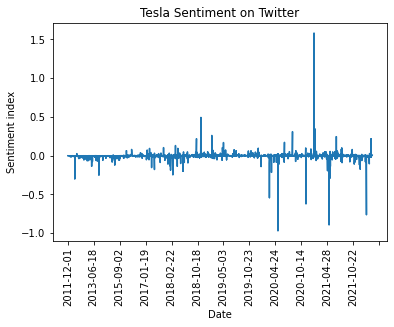

In [158]:
fig, ax = plt.subplots()

x = Joined.index
y = Joined['Analysis']

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Sentiment index')
plt.title('Tesla Sentiment on Twitter')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

According to the Ljung-Box test we fail to reject H0=autocorrelation

In [159]:
sm.stats.acorr_ljungbox(Joined['Analysis'], lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,13.088008,0.218793


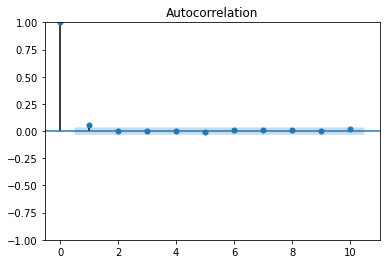

In [160]:
tsaplots.plot_acf(Joined['Analysis'], lags=10)
plt.show()

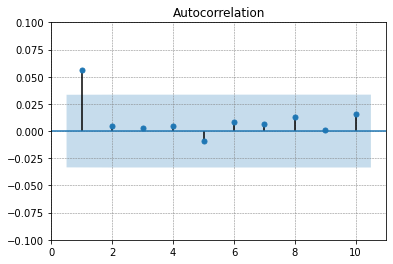

In [161]:
tsaplots.plot_acf(Joined['Analysis'], lags=10, alpha = 0.05, zero = False)

scale_factor = 0.1

ymin, ymax = plt.ylim()
plt.ylim(ymin * scale_factor, ymax * scale_factor)

plt.grid(which="major", color="grey", linestyle="--", linewidth=0.5)

plt.show()

We fitted the ARIMA model picking the best model by minimizing the AIC. We find that the best fit is obtained using a (1,0,0) model

In [162]:
AIC = np.inf
p = q = d = range(0,3)
pdq = list(itertools.product(p, d, q))
for comb in pdq:
    model = ARIMA(Joined['Analysis'], order = comb)
    fit = model.fit()
    if fit.aic<AIC:
        AIC = fit.aic
        best_model = fit
        
summary_tesla_sentiment = best_model.summary()

C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no ass

In [163]:
print(summary_tesla_sentiment)

                               SARIMAX Results                                
Dep. Variable:               Analysis   No. Observations:                 3444
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5650.981
Date:                Thu, 10 Mar 2022   AIC                         -11295.962
Time:                        23:56:26   BIC                         -11277.529
Sample:                             0   HQIC                        -11289.378
                               - 3444                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -2.177      0.030      -0.004      -0.000
ar.L1          0.0560      0.011      5.090      0.000       0.034       0.078
sigma2         0.0022    3.4e-06    647.188      0.0

#### Checked if the index is a good predictor for TSLA return (Granger causality test)

Since the p-value is 0.53 thus we fail to reject H0, so that our sentiment index doesn't seem to drive the price movement at lags up until 10

In [173]:
grangercausalitytests(Joined[['log_ret','Analysis']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9051  , p=0.5274  , df_denom=3413, df_num=10
ssr based chi2 test:   chi2=9.1068  , p=0.5220  , df=10
likelihood ratio test: chi2=9.0948  , p=0.5231  , df=10
parameter F test:         F=0.9051  , p=0.5274  , df_denom=3413, df_num=10


{10: ({'ssr_ftest': (0.90511136421576, 0.5273914151783867, 3413.0, 10),
   'ssr_chi2test': (9.106804643178787, 0.5219983630971988, 10),
   'lrtest': (9.094750543394184, 0.5231356726956522, 10),
   'params_ftest': (0.9051113642158007, 0.5273914151783867, 3413.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1.

We also carried out the opposite analysis, meaning checking whether the price movement can explain the sentiment index at lags up to 10. In this case the p-value is very small, p-value=0.001, thus we reject H0 meaning there exist casuality between the two series, even if in the opposite direction then expected. Thus, we can conclude that knowing the TSLA stock movements is useful for predicting the future sentiment on Twitter around this topic.

In [174]:
grangercausalitytests(Joined[['Analysis','log_ret']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9789  , p=0.0010  , df_denom=3413, df_num=10
ssr based chi2 test:   chi2=29.9721 , p=0.0009  , df=10
likelihood ratio test: chi2=29.8421 , p=0.0009  , df=10
parameter F test:         F=2.9789  , p=0.0010  , df_denom=3413, df_num=10


{10: ({'ssr_ftest': (2.9788824620724688, 0.0009610013764514804, 3413.0, 10),
   'ssr_chi2test': (29.972113609015114, 0.0008656843841289708, 10),
   'lrtest': (29.842070732382126, 0.0009090973277971912, 10),
   'params_ftest': (2.97888246207249, 0.0009610013764514804, 3413.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## VIRGIN GALACTIC ANALYSIS

In [5]:
Rich_Branson=collect_tweets(user="richardbranson", n_tweets=np.inf, min_date="2019-10-28")

In [6]:
word1='space'
word2='flight'

ms1 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word1]]]), n=100)
ms2 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word2]]]), n=100)
VG_syn = [nlp.vocab.strings[w] for w in ms1[0][0]]
VG2_syn = [nlp.vocab.strings[w] for w in ms2[0][0]]
VG_syn.extend(VG2_syn)
VG_syn.extend(['Virgin Galactic', 'SPCE', 'flight to space', 'Nyse', 'NYSE'])
print(VG_syn)

['SPACE', 'space', 'SPACES', 'ROOM', 'room', 'storage', 'safe-keeping', 'AREA', 'area', 'FLOOR', 'inside', 'INside', 'BUIDING', 'building', 'Medium-size', 'large', 'LARGER', 'livng', 'living', 'compactified', 'where', 'Where', 'WHERe', 'HALF-FILLED', 'square', 'sq.', 'OPen', 'open', 'APOGEE', 'ouside', 'outside', 'PLACE', 'place', 'BEYOND', 'beyond', 'HOMEWORLD', 'planet', 'RELOCATE', 'move', 'Possiblities', 'MOVERS', 'moving', 'occupy', 'Situate', 'FREE-FLYING', 'COSMOS', 'universe', 'INTERIORS', 'sub-basement', 'SCALED-DOWN', 'Accomodate', 'Withing', 'within', 'OBJECTS', 'CONSTELLATIONS', 'there', 'There', 'THere', 'ENVIROMENT', 'POSSIBLE', 'possible', 'future', 'FUTURE', 'ARCHWAYS', 'stucture', 'vitual', 'virtual', 'intothe', 'Into', 'into', 'AMBIANCE', 'location', 'LOCATION', 'VALET', 'REOCCUPIED', 'enough', 'ENOUGH', 'Enough', 'Side-By-Side', 'One-Room', 'small', 'one-person', 'CONCEPT', 'gound', 'ground', 'demensions', 'Wall-To-Wall', 'house', 'Hous', 'TWO-CAR', 'WALL', 'wall', '

In [7]:
VG = Rich_Branson

sent=[]
subj=[]

for j in range(0,len(Rich_Branson)):
    
    row = Rich_Branson.iloc[j]
    content = row['content']
    
    if any(word in content for word in VG_syn):
        
        doc = nlp(content)
    
        sent.append(doc._.blob.polarity)
        subj.append(doc._.blob.subjectivity)
        
    else:
        
        VG = VG.drop(labels=j, axis=0)

In [8]:
VG['Sentiment']=sent
VG['Subjectivity']=subj

VG.reset_index(inplace = True)
VG = VG.drop(columns=['index'])

VG['Objectivity']= 1 - VG['Subjectivity']
VG['Controversy']= VG['reply count']/VG['like Count']

Av_follower = 707
Av_CTR = 0.0164

VG['Direct Effect']=VG['Objectivity']*VG['Sentiment']*VG['like Count']
VG['Debate']=VG['Controversy']*VG['Subjectivity']*VG['retweet count']
VG['Indirect Effect']=VG['retweet count']*Av_follower*Av_CTR*VG['Sentiment']

MDirect=abs(VG['Direct Effect']).max()
MDebate = abs(VG['Debate']).max()
MIndirect = abs(VG['Indirect Effect']).max()

VG['Direct Effect']=VG['Direct Effect']/MDirect
VG['Debate'] = VG['Debate']/MDebate
VG['Indirect Effect'] = VG['Indirect Effect']/MIndirect

VG['Analysis']=VG['Direct Effect']+VG['Indirect Effect']-VG['Debate']

In [9]:
VG

,date,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
0,2022-03-08 19:39:52+00:00,The solutions all exist. I believe the global ...,197,24,26,0.152778,0.329167,0.670833,0.121827,0.002644,0.003844,0.001198,-0.000001
1,2022-03-08 19:39:48+00:00,"UK and EU must do the same. Yes, economic repe...",98,14,18,0.097222,0.406349,0.593651,0.142857,0.000741,0.003852,0.000528,-0.002584
2,2022-03-08 19:39:48+00:00,Heartened to see the US government ban the imp...,544,80,80,0.050000,0.475000,0.525000,0.147059,0.001870,0.020602,0.001207,-0.017525
3,2022-03-08 18:04:52+00:00,Partnering is the perfect book to learn how to...,53,4,7,0.744444,0.827778,0.172222,0.075472,0.000890,0.001612,0.001572,0.000850
4,2022-03-08 18:04:51+00:00,I’ve spent 18 years in awe of @JeanOelwang – w...,15,2,1,0.092857,0.317857,0.682143,0.133333,0.000124,0.000156,0.000028,-0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2019-10-29 09:45:09+00:00,Tansghart was the first @EveBranson Foundation...,228,10,22,0.147727,0.547980,0.452020,0.043860,0.001994,0.001949,0.000981,0.001025
503,2019-10-28 18:25:08+00:00,Celebrating the first day of trading for the w...,390,34,81,0.100000,0.366667,0.633333,0.087179,0.003235,0.009546,0.002444,-0.003867
504,2019-10-28 18:03:38+00:00,@virgingalactic @NYSE What a great day – Congr...,45,3,8,0.800000,0.750000,0.250000,0.066667,0.001179,0.001475,0.001931,0.001635
505,2019-10-28 17:25:06+00:00,"For the first time, anyone will have the chanc...",181,21,35,0.125000,0.216667,0.783333,0.116022,0.002321,0.003244,0.001320,0.000397


From the descriptive statistics we can see that this series is shorter than the Tesla one. This is due that Virgin Galactic has been enlisted quite recently so fewer observations are available

In [12]:
start = dt.datetime(2019,10,28)
end = dt.datetime(2022,3,9)

Virgin_Galactic_Return = web.DataReader('SPCE', "yahoo", start, end)
Virgin_Galactic_Return['log_ret'] = np.log(Virgin_Galactic_Return['Adj Close']) - np.log(Virgin_Galactic_Return['Adj Close'].shift(1))
Virgin_Galactic_Return['log_ret']=Virgin_Galactic_Return['log_ret'].fillna(0)

In [14]:
VG['date']=VG['date'].map(date_change)
VG.rename({'date': 'Date'}, axis=1, inplace=True)
Virgin_Galactic_Return.index = Virgin_Galactic_Return.index.map(str)
Virgin_Galactic_Return.index = Virgin_Galactic_Return.index.map(lambda x : x[:10])
Joined=pd.merge(Virgin_Galactic_Return, VG, on=['Date'], how='inner')

In [15]:
Joined = Joined.set_index('Date')
Joined

,High,Low,Open,Close,Volume,Adj Close,log_ret,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
Date,,,,,,,,,,,,,,,,,,,
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,Celebrating the first day of trading for the w...,390,34,81,0.100000,0.366667,0.633333,0.087179,0.003235,0.009546,0.002444,-0.003867
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,@virgingalactic @NYSE What a great day – Congr...,45,3,8,0.800000,0.750000,0.250000,0.066667,0.001179,0.001475,0.001931,0.001635
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,"For the first time, anyone will have the chanc...",181,21,35,0.125000,0.216667,0.783333,0.116022,0.002321,0.003244,0.001320,0.000397
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,Delighted to be on the @NYSE trading room floo...,327,28,59,0.190000,0.440000,0.560000,0.085627,0.004557,0.008195,0.003382,-0.000256
2019-10-29,12.090,10.50,12.04,10.99,6324000,10.99,-0.070266,@adambain Thanks for joining us on the journey...,12,0,0,0.250000,0.200000,0.800000,0.000000,0.000314,0.000000,0.000000,0.000314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08,7.829,7.05,7.40,7.42,17984700,7.42,0.008119,The solutions all exist. I believe the global ...,197,24,26,0.152778,0.329167,0.670833,0.121827,0.002644,0.003844,0.001198,-0.000001
2022-03-08,7.829,7.05,7.40,7.42,17984700,7.42,0.008119,"UK and EU must do the same. Yes, economic repe...",98,14,18,0.097222,0.406349,0.593651,0.142857,0.000741,0.003852,0.000528,-0.002584
2022-03-08,7.829,7.05,7.40,7.42,17984700,7.42,0.008119,Heartened to see the US government ban the imp...,544,80,80,0.050000,0.475000,0.525000,0.147059,0.001870,0.020602,0.001207,-0.017525


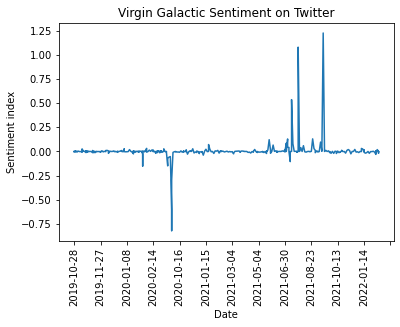

In [16]:
fig, ax = plt.subplots()

x = Joined.index
y = Joined['Analysis']

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Sentiment index')
plt.title('Virgin Galactic Sentiment on Twitter')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

From the Ljung-Box test and ACF function we reject H0, thus there exist autocorrelation

In [17]:
sm.stats.acorr_ljungbox(Joined['Analysis'], lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,29.712183,0.000955


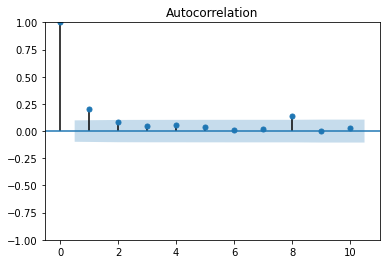

In [18]:
tsaplots.plot_acf(Joined['Analysis'], lags=10)
plt.show()

Fitting for the best ARIMA model we find once again a (1,0,0) to be the best model minimizing the AIC criterion

In [21]:
AIC = np.inf
p = q = d = range(0,3)
pdq = list(itertools.product(p, d, q))
for comb in pdq:
    model = ARIMA(Joined['Analysis'], order = comb)
    fit = model.fit()
    if fit.aic<AIC:
        AIC = fit.aic
        best_model = fit
        
summary_VG_sentiment = best_model.summary()

C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no ass

In [22]:
print(summary_VG_sentiment)

                               SARIMAX Results                                
Dep. Variable:               Analysis   No. Observations:                  395
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 342.599
Date:                Fri, 11 Mar 2022   AIC                           -679.199
Time:                        00:26:16   BIC                           -667.262
Sample:                             0   HQIC                          -674.469
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.009      0.396      0.692      -0.014       0.022
ar.L1          0.2002      0.019     10.305      0.000       0.162       0.238
sigma2         0.0103      0.000     67.686      0.0

#### Granger causality test

By looking at Granger casuality we fail to reject H0, so that no casuality is present in both directions

In [28]:
grangercausalitytests(Joined[['log_ret','Analysis']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5445  , p=0.8581  , df_denom=364, df_num=10
ssr based chi2 test:   chi2=5.7593  , p=0.8351  , df=10
likelihood ratio test: chi2=5.7167  , p=0.8385  , df=10
parameter F test:         F=0.5445  , p=0.8581  , df_denom=364, df_num=10


{10: ({'ssr_ftest': (0.5445177153071784, 0.8581085836275366, 364.0, 10),
   'ssr_chi2test': (5.759321988825926, 0.8350623233739434, 10),
   'lrtest': (5.7166691838024235, 0.8384792416061829, 10),
   'params_ftest': (0.5445177153071774, 0.8581085836275366, 364.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1

In [29]:
grangercausalitytests(Joined[['Analysis','log_ret']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1226  , p=0.3439  , df_denom=364, df_num=10
ssr based chi2 test:   chi2=11.8735 , p=0.2936  , df=10
likelihood ratio test: chi2=11.6941 , p=0.3061  , df=10
parameter F test:         F=1.1226  , p=0.3439  , df_denom=364, df_num=10


{10: ({'ssr_ftest': (1.1225859197457002, 0.3438883759348278, 364.0, 10),
   'ssr_chi2test': (11.873504920387216, 0.29361157973604796, 10),
   'lrtest': (11.694093265602078, 0.30605126872479116, 10),
   'params_ftest': (1.1225859197456916, 0.343888375934838, 364.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          